# 1D CNN 코드
- ANNIE 2023.11.24
- Simple CNN Pytorch 구현

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 신호 시각화

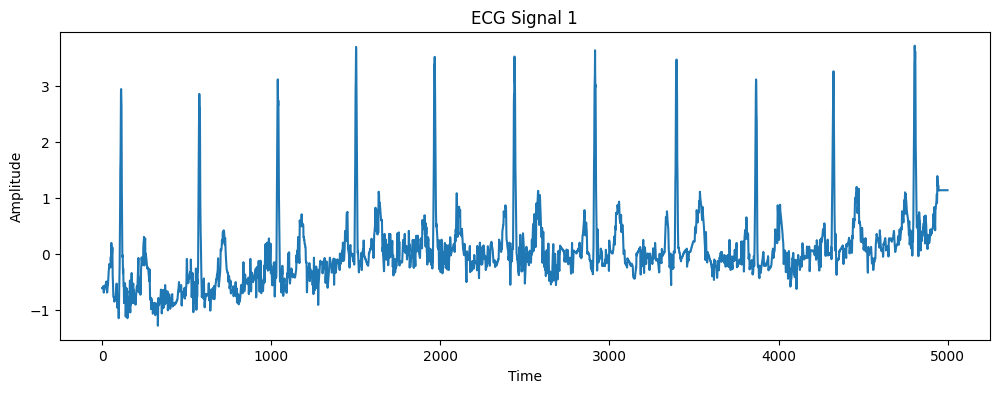

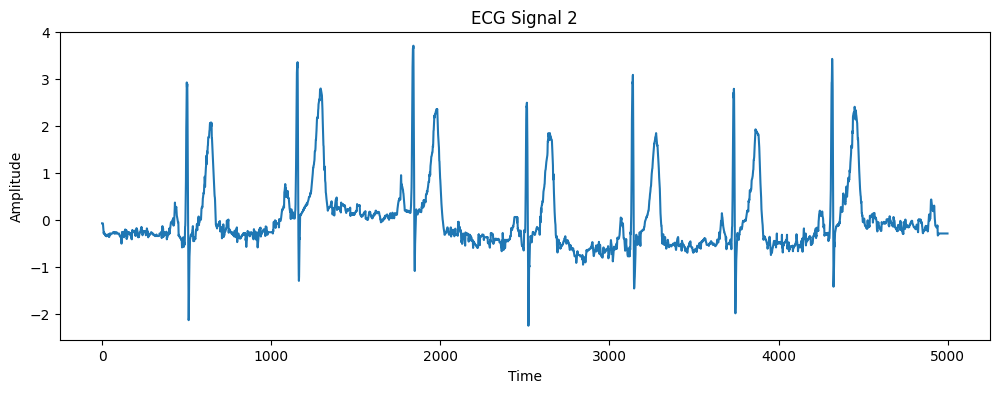

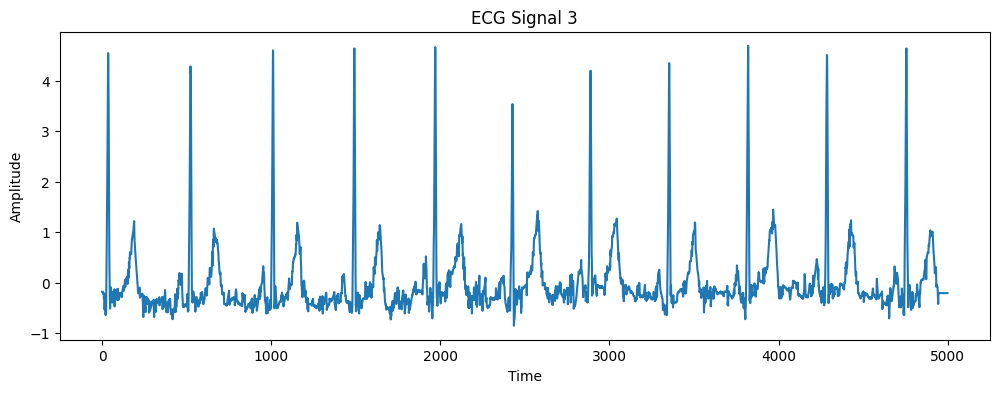

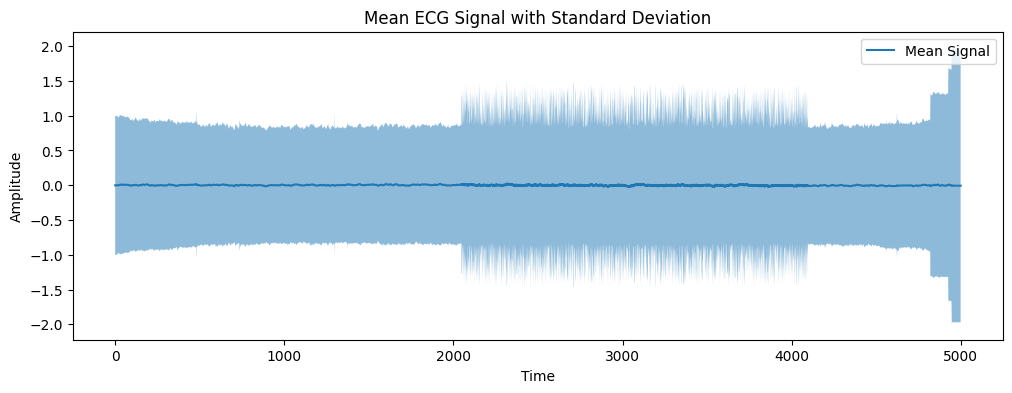

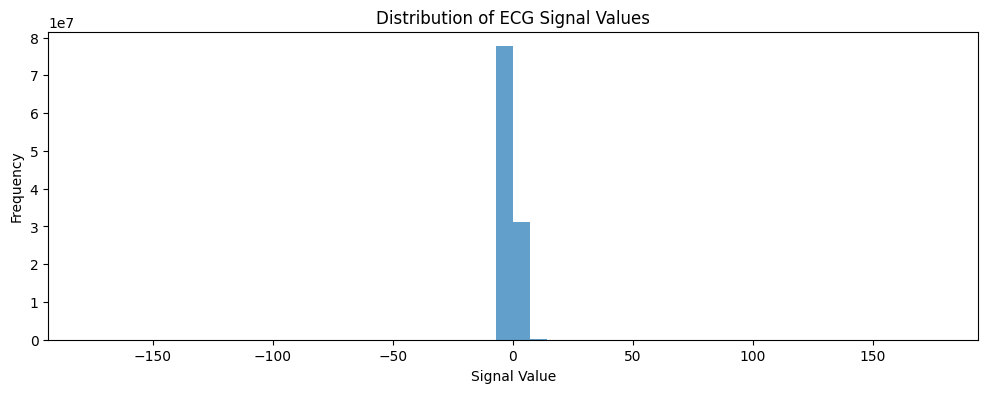

In [3]:
# custom_file 폴더에서 lead1_signals 데이터 로드
lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')

# 데이터 정규화
lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / lead1_signals.std()

# 개별 신호 시각화
def plot_ecg_signal(signal, title="ECG Signal"):
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

# 몇 개의 신호 시각화
for i in range(3):
    plot_ecg_signal(lead1_signals_normalized[i], title=f"ECG Signal {i+1}")

# 평균 신호 및 표준 편차 시각화
mean_signal = np.mean(lead1_signals_normalized, axis=0)
std_signal = np.std(lead1_signals_normalized, axis=0)

plt.figure(figsize=(12, 4))
plt.plot(mean_signal, label='Mean Signal')
plt.fill_between(range(len(mean_signal)), mean_signal-std_signal, mean_signal+std_signal, alpha=0.5)
plt.title('Mean ECG Signal with Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# 데이터 분포
plt.figure(figsize=(12, 4))
plt.hist(lead1_signals_normalized.flatten(), bins=50, alpha=0.7)
plt.title('Distribution of ECG Signal Values')
plt.xlabel('Signal Value')
plt.ylabel('Frequency')
plt.show()

# 이상치 확인

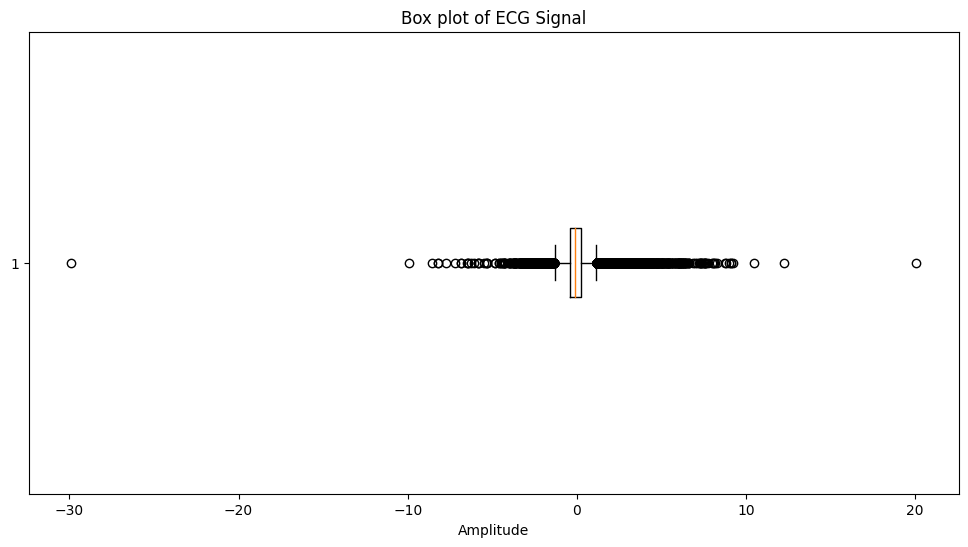

In [4]:
# 신호 데이터의 첫 번째 채널에서 박스 플롯 생성
plt.figure(figsize=(12, 6))
plt.boxplot(lead1_signals_normalized[:, 0], vert=False)
plt.title('Box plot of ECG Signal')
plt.xlabel('Amplitude')
plt.show()

# AFIB 라벨링

In [5]:
df = pd.read_csv('./ptb_xl_data/ptbxl_database.csv', index_col='ecg_id')
df.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [6]:
import ast
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
df.scp_codes = df.scp_codes.apply(lambda x: list(x.keys()))
df.scp_codes

ecg_id
1               [NORM, LVOLT, SR]
2                   [NORM, SBRAD]
3                      [NORM, SR]
4                      [NORM, SR]
5                      [NORM, SR]
                   ...           
21833    [NDT, PVC, VCLVH, STACH]
21834           [NORM, ABQRS, SR]
21835                 [ISCAS, SR]
21836                  [NORM, SR]
21837                  [NORM, SR]
Name: scp_codes, Length: 21799, dtype: object

In [7]:
df['label'] = df.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)
df.label.value_counts()

label
0    20285
1     1514
Name: count, dtype: int64

In [8]:
fold_distribution = df.groupby(['strat_fold', 'label']).size().unstack(fill_value=0)
fold_distribution

label,0,1
strat_fold,,
1,2024,151
2,2030,151
3,2041,151
4,2023,151
5,2022,152
6,2022,151
7,2024,152
8,2021,152
9,2032,151


# 모델 구축

In [9]:
train_data = df[df['strat_fold'].isin(range(1, 9))]
train_data.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,label
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,0
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,0
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,0
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,0
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,0


In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


# custom_file 폴더에서 lead1_signals 데이터 로드
lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')


# 레이블 데이터 로드
labels = df['label'].values


# 데이터 정규화
lead1_signals_normalized = (lead1_signals - lead1_signals.mean(axis=0)) / lead1_signals.std(axis=0)


# 데이터셋을 텐서로 변환
X = torch.Tensor(lead1_signals_normalized)
Y = torch.Tensor(labels).long()  # 레이블 데이터를 long 타입의 텐서로 변환


# 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


# 채널 수를 1로 추가
X_train = X_train.unsqueeze(1)
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)


# DataLoader 생성
train_data = TensorDataset(X_train, Y_train)
val_data = TensorDataset(X_val, Y_val)
test_data = TensorDataset(X_test, Y_test)

batch_size = 64
# 마지막 불완전한 배치를 버림
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, drop_last=True)


# 간단한 CNN 모델 구축
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 32, kernel_size=5, stride=1) #output 4996
        self.pool = torch.nn.MaxPool1d(kernel_size=2, stride=2) # 2498
        self.conv2 = torch.nn.Conv1d(32, 64, kernel_size=5) # 2494
        self.fc1 = torch.nn.Linear(64 * 1247, 1000) 
        self.fc2 = torch.nn.Linear(1000, 500)
        self.fc3 = torch.nn.Linear(500, 2)  # 클래스가 2개이므로 출력 크기를 2로 설정

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 1247) 
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

# 모델학습

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 모델을 GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# 손실 함수 정의 (크로스 엔트로피)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 선택 (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 학습 및 검증 손실과 정확도를 기록할 리스트
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 학습 루프 설정
num_epochs = 10
for epoch in range(num_epochs):
    # 훈련 데이터 루프
    model.train()
    train_accuracy = 0
    train_loss = 0.0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
        optimizer.zero_grad()  # 그래디언트 초기화

        # 순전파 및 역전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy / total)

    # 검증 데이터 루프
    model.eval()
    val_accuracy = 0
    val_loss = 0.0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy / total)

    # 에포크의 결과 출력
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {train_losses[-1]:.4f} - Training Accuracy: {train_accuracies[-1]:.4f} - Validation Loss: {val_losses[-1]:.4f} - Validation Accuracy: {val_accuracies[-1]:.4f}')

# 테스트 데이터 루프
model.eval()
test_accuracy = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc=f"Testing"):
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

test_accuracy /= len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10 - Validation: 100%|██████████| 68/68 [00:00<00:00, 122.14it/s]


Epoch [1/10] - Training Loss: 0.2735 - Training Accuracy: 0.9249 - Validation Loss: 0.2330 - Validation Accuracy: 0.9334


Epoch 2/10 - Validation: 100%|██████████| 68/68 [00:00<00:00, 113.30it/s]


Epoch [2/10] - Training Loss: 0.2373 - Training Accuracy: 0.9290 - Validation Loss: 0.2496 - Validation Accuracy: 0.9334


Epoch 3/10 - Validation: 100%|██████████| 68/68 [00:00<00:00, 121.58it/s]


Epoch [3/10] - Training Loss: 0.2148 - Training Accuracy: 0.9305 - Validation Loss: 0.2315 - Validation Accuracy: 0.9331


Epoch 4/10 - Validation: 100%|██████████| 68/68 [00:00<00:00, 115.01it/s]


Epoch [4/10] - Training Loss: 0.1827 - Training Accuracy: 0.9373 - Validation Loss: 0.2619 - Validation Accuracy: 0.9313


Epoch 5/10 - Validation: 100%|██████████| 68/68 [00:00<00:00, 121.87it/s]


Epoch [5/10] - Training Loss: 0.1254 - Training Accuracy: 0.9569 - Validation Loss: 0.3424 - Validation Accuracy: 0.9219


Epoch 6/10 - Validation: 100%|██████████| 68/68 [00:00<00:00, 124.12it/s]


Epoch [6/10] - Training Loss: 0.0505 - Training Accuracy: 0.9833 - Validation Loss: 0.4229 - Validation Accuracy: 0.9111


Epoch 7/10 - Validation: 100%|██████████| 68/68 [00:00<00:00, 122.02it/s]


Epoch [7/10] - Training Loss: 0.0154 - Training Accuracy: 0.9956 - Validation Loss: 0.5381 - Validation Accuracy: 0.9235


Epoch 8/10 - Validation: 100%|██████████| 68/68 [00:00<00:00, 120.53it/s]


Epoch [8/10] - Training Loss: 0.0041 - Training Accuracy: 0.9990 - Validation Loss: 0.8210 - Validation Accuracy: 0.9088


Epoch 9/10 - Validation: 100%|██████████| 68/68 [00:00<00:00, 118.77it/s]


Epoch [9/10] - Training Loss: 0.0300 - Training Accuracy: 0.9953 - Validation Loss: 0.5852 - Validation Accuracy: 0.9244


Epoch 10/10 - Validation: 100%|██████████| 68/68 [00:00<00:00, 122.00it/s]


Epoch [10/10] - Training Loss: 0.0036 - Training Accuracy: 0.9992 - Validation Loss: 0.7605 - Validation Accuracy: 0.9168


Testing: 100%|██████████| 68/68 [00:00<00:00, 126.43it/s]

Test Accuracy: 91.88%


In [1]:
# 손실 그래프 그리기
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

NameError: name 'plt' is not defined

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# 모델을 평가 모드로 설정
model.eval()

# 모든 예측과 레이블을 저장할 리스트 초기화
all_predictions = []
all_labels = []

# 테스트 데이터에 대한 예측 수행
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 성능 지표 계산
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# 혼동 행렬 생성
cm = confusion_matrix(all_labels, all_predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 성능 지표 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

NameError: name 'model' is not defined

In [3]:
from sklearn.metrics import roc_curve, auc

# 예측 확률을 저장할 리스트
all_preds_probs = []

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터에 대한 예측 확률 수행
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        # softmax를 사용하여 확률을 계산
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_preds_probs.extend(probs.cpu().numpy())

# 실제 레이블과 예측 확률을 사용하여 ROC 커브 계산
fpr, tpr, _ = roc_curve(all_labels, [p[1] for p in all_preds_probs])
roc_auc = auc(fpr, tpr)

# AUROC 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# AUROC 점수를 출력합니다.
print(f'AUROC: {roc_auc:.2f}')

NameError: name 'model' is not defined